In [1]:
from skimage import data, io, filters, restoration
from skimage.util import view_as_windows as viewW
from matplotlib import pyplot as plt
import cv2 as cv
import scipy
import numpy
import math
import os
import random

In [2]:
def im2col_sliding_strided_v2(A, BSZ, stepsize=1):
    return viewW(A, (BSZ[0],BSZ[1])).reshape(-1,BSZ[0]*BSZ[1]).T[:,::stepsize]

def im2col_sliding_broadcasting(A, BSZ, stepsize=1):
    # Parameters
    M,N = A.shape
    col_extent = N - BSZ[1] + 1
    row_extent = M - BSZ[0] + 1

    # Get Starting block indices
    start_idx = numpy.arange(BSZ[0])[:,None]*N + numpy.arange(BSZ[1])

    # Get offsetted indices across the height and width of input array
    offset_idx = numpy.arange(row_extent)[:,None]*N + numpy.arange(col_extent)

    # Get all actual indices & index into input array for final output
    return numpy.take (A,start_idx.ravel()[:,None] + offset_idx.ravel()[::stepsize])


## Resources

- Source code: https://uk.mathworks.com/matlabcentral/fileexchange/36921-noise-level-estimation-from-a-single-image
- MATLAB to python: https://cheatsheets.quantecon.org/, http://mathesaurus.sourceforge.net/matlab-numpy.html



In [3]:
"""
Output params:
nlevel: estimated noise level
th: threshold to extract weak texture patches at the last iteration
num: number of extracted weak texture patches

Input Params:
img: intput single image
patchsize (optional): patch size(default: 7)
decim (optional): decimation factor. Large number = accelerated calculation 
                  (default: 0)
conf (optional): confidence interval to determin the treshold for the 
                 weak texture. usually very close to one (default: 0.99)
itr (optional): number of iterations (default: 3)
"""

def NoiseLevel(img, patchsize = 7, decim = 0, conf = None, itr = 3):
    img = img.astype(numpy.float32)
    if not conf:
        conf = 1-1e-6
    kh = numpy.array([[[-1/2],[0],[1/2]]])
    imgh = scipy.ndimage.correlate(img, kh, mode="nearest")
    imgh = imgh[:,1:len(imgh[1])-1,:]
    imgh = numpy.multiply(imgh, imgh)
    
    kv = numpy.array([[[-1/2]],[[0]],[[1/2]]])
    imgv = scipy.ndimage.correlate(img, kv, mode="nearest")
    imgv = imgv[1:len(imgv)-1,:,:]
    imgv = numpy.multiply(imgv, imgv)
    
    
    Dh = my_convmtx(kh, patchsize, patchsize)
    Dv = my_convmtx(kv, patchsize, patchsize)
    DD = Dh.conj().transpose().dot(Dh)\
         +Dv.conj().transpose().dot(Dv)
    r = numpy.linalg.matrix_rank(DD)
    Dtr = DD.trace(offset=0);
    tau0 = scipy.stats.gamma.ppf(conf,float(r)/2, scale = 2.0 * Dtr / float(r));
    
    nlevel = []
    th = []
    num = []
    for cha in range(img.shape[2]):
        X = im2col_sliding_broadcasting(img[:,:,cha],(patchsize, patchsize))
        Xh = im2col_sliding_broadcasting(imgh[:,:,cha],(patchsize, patchsize-2))
        Xv = im2col_sliding_broadcasting(imgv[:,:,cha],(patchsize-2, patchsize))

        Xtr = numpy.vstack((Xh,Xv)).sum(axis=0)
        if decim > 0:
            XtrX = numpy.vstack((Xtr,X));
            XtrX = sortrows(XtrX.conj().transpose())
            p = math.floor(XtrX.shape[1]/(decim+1))
            p = numpy.array(range(0,p)) * (decim+1)
            Xtr = XtrX[1].take(p, axis=1)
            X = XtrX[2:size(XtrX,1)].take(p, axis=1)
        # Noise level estimation
        tau = math.inf
        if X.shape[1] < X.shape[0]:
            sig2 = 0
        else:
            cov = X.dot((X.conj().T))/(X.shape[1]-1)
            d = numpy.linalg.eigvals(cov)
            d.sort()
            sig2 = d[0]
        for i in range(2,itr+1):
            # weak texture selection
            tau = sig2 * tau0
            #p = [1 if pp < tau else 0 for pp in Xtr]
            p = Xtr<tau
            Xtr = Xtr[p]
            X = X[:,p==1]
            
            # noise level estimation
            if X.shape[1] < X.shape[0]:
                break

            cov = X.dot((X.conj().T))/(X.shape[1]-1)
            d = numpy.linalg.eigvals(cov)
            d.sort()
            sig2 = d[0]
        nlevel.append(math.sqrt(sig2))
        th.append(tau)
        num.append(X.shape[1])
    
    return nlevel, th, num
            
            
        

In [4]:
def my_convmtx(H, m, n):
    s = H.shape
    T = numpy.zeros((((m-s[0]+1)*(n-s[1]+1)), (m*n)), float)
    k = 0
    for i in range(1,(m-s[0]+2)):
        for j in range(1,(n-s[1]+2)):
            for p in range(1,s[0]+1):
                h_index = p-1
                for x in range((i-1+p-1)*n+(j-1),(i-1+p-1)*n+(j-1)+s[1]):
                    T[k,x] = H.flatten()[h_index]
                    h_index += 1
            k += 1
    return T
    
        

In [5]:
"""
Output parameters:
msk: weak texture mask. 0 and 1 represent non-weak-texture and weak-texture
     respectively

Input Parameters:
img: input single image
th: threshold which is output of NoiseLevel
patchsize (optional): patchsize (default: 7)
"""
def weak_texture_mask(img, th, patchsize=7):
    img = img.astype(numpy.float32) #*(1/255))

    kh = numpy.array([[[-1/2],[0],[1/2]]])
    imgh = scipy.ndimage.correlate(img.astype(numpy.float32), kh, mode="nearest")
    imgh = imgh[:,1:len(imgh[1])-1,:]
    imgh = numpy.multiply(imgh, imgh)
    
    kv = numpy.array([[[-1/2]],[[0]],[[1/2]]])
    imgv = scipy.ndimage.correlate(img.astype(numpy.float32), kv, mode="nearest")
    imgv = imgv[1:len(imgv)-1,:,:]
    imgv = numpy.multiply(imgv, imgv)
    
    
    s = img.shape
    msk = numpy.zeros(s, float)
    
    for cha in range(0,s[2]):
        Xh = im2col_sliding_broadcasting(imgh[:,:,cha],(patchsize, patchsize-2))
        Xv = im2col_sliding_broadcasting(imgv[:,:,cha],(patchsize-2, patchsize))

        Xtr = numpy.vstack((Xh,Xv)).sum(axis=0)
        
        p = [pp < th[cha] for pp in Xtr]
        ind = 0
        for col in range(s[0]-patchsize+1):
            for row in range(s[1]-patchsize+1):
                if p[ind]:
                    msk[col:col+patchsize,row:row+patchsize, cha] = 1
                ind += 1
    return msk

    

In [6]:
test_image = cv.imread('images/42078.jpg')
test_image = test_image[:,:,::-1]


In [7]:
def add_gaussian_noise(img):
    m = (0,0,0) 
    s = (1,1,1)  
    noise = numpy.zeros(img.shape)
    cv.randn(noise,m,s)
    print(noise.min(), noise.max())
    new_img = (img+noise) 
    new_img = (new_img - new_img.min()) * (255/new_img.max())
    return new_img

[0.2531898221267512, 0.25197274940481923, 0.2911626569078624] [9.234120865679499, 8.96987145541392, 10.42811114533607] [64928, 68376, 73757]


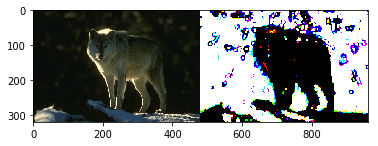

-4.8281474113464355 4.650505542755127
[0.9965520989851089, 0.9962075888410882, 1.0161337432560866] [85.48960641891007, 85.33837339427261, 88.18252463484676] [66396, 68904, 74033]


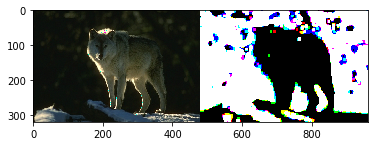

In [8]:
nlevel, th, num = NoiseLevel(test_image,4)
print(nlevel, th, num)
msk1 = weak_texture_mask(test_image, th, 4 )
disp1 = numpy.hstack((test_image,msk1.astype(numpy.uint8) * 255))
plt.imshow(disp1)
plt.show()

noisy_image = add_gaussian_noise(test_image)
nlevel, th, num = NoiseLevel(noisy_image)
print(nlevel, th, num)
msk2 = weak_texture_mask(noisy_image, th )
disp2 = numpy.hstack((noisy_image.astype(numpy.uint8),msk2.astype(numpy.uint8) * 255))
plt.imshow(disp2)
plt.show()

-4.445255756378174 4.674343109130859
Fitness when applying no denoising algorithm:  96169807
-------------
Fitness after applying denoising algorithm:  68649297


/home/sam/.local/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


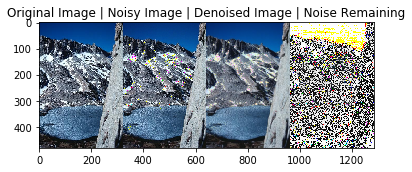


Testing fitness funtion with optional display parameter:


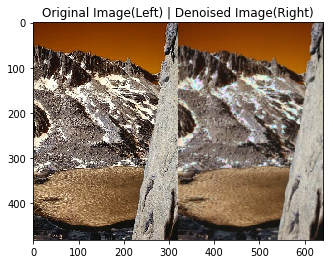

Result:  5872.253315380732


In [125]:
def evaluate_fitness(denoised_image, original_image, display_images=False):
    
    if display_images:
        
        merged_images = numpy.hstack((original_image,denoised_image))
        plt.title("Original Image(Left) | Denoised Image(Right)")
        plt.imshow(merged_images)
        plt.show()
        
    return math.sqrt(((numpy.absolute(original_image) - numpy.absolute(denoised_image))**2).sum())

fitness_test_image = cv.imread('images/167083.jpg')

noisy_test_images = fitness_test_image.copy()

noisy_test_images = add_gaussian_noise(noisy_test_images).astype(numpy.uint8)

denoised_test_image = filters.gaussian(noisy_test_images,sigma=1)
denoised_test_image *= 255
denoised_test_image = denoised_test_image.astype(numpy.uint8)

baseline = fitness_test_image - noisy_test_images

test_fitness = fitness_test_image - denoised_test_image

print("Fitness when applying no denoising algorithm: ",numpy.absolute(baseline).sum())
print("-------------")
print("Fitness after applying denoising algorithm: ", numpy.absolute(test_fitness).sum())

all_images_merged = numpy.hstack((fitness_test_image,noisy_test_images,denoised_test_image,test_fitness))
rgb_all_images = cv.cvtColor(all_images_merged, cv.COLOR_BGR2RGB)
plt.imshow(rgb_all_images)
plt.title("Original Image | Noisy Image | Denoised Image | Noise Remaining")
plt.show()

print("\nTesting fitness funtion with optional display parameter:")
print("Result: ", evaluate_fitness(denoised_test_image, fitness_test_image, display_images=True))

In [126]:
class ImageDataset:
    
    def __init__(self, size):
        self.dir_location = "images/"
        self.base_images = []
        self.noisy_images = []
        self.weak_texture_masks = []
        self.load_files(size)
        
        
    def load_files(self, size):
        self.base_images = []
        for image_name in os.listdir(self.dir_location):
            if len(self.base_images) > size:
                break
            new_image = cv.imread(self.dir_location+image_name);
            new_image = new_image[:,:,::-1]
            self.base_images += [new_image]
            noisy_image = add_gaussian_noise(new_image)
            self.noisy_images += [noisy_image]
            try:
                nlevel, th, num = NoiseLevel(new_image,5)
                new_image_mask = weak_texture_mask(noisy_image,th,5)
                self.weak_texture_masks += [new_image_mask]
            except:
                plt.imshow(new_image)
                plt.show()
            
            
            
        

In [127]:
images = ImageDataset(1)

-4.620902061462402 4.5191850662231445
-4.590716361999512 4.828517436981201


[[[ 29  57  71]
  [ 34  62  76]
  [ 30  57  74]
  ...
  [136 150 163]
  [101 115 126]
  [111 121 131]]

 [[ 31  59  73]
  [ 30  58  72]
  [ 30  57  74]
  ...
  [128 142 155]
  [132 146 159]
  [166 178 190]]

 [[ 33  61  75]
  [ 29  57  71]
  [ 30  58  72]
  ...
  [139 155 168]
  [ 75  91 106]
  [ 84 100 115]]

 ...

 [[ 22  39  47]
  [ 20  39  46]
  [ 26  44  54]
  ...
  [124 128 137]
  [109 113 122]
  [118 122 131]]

 [[ 29  48  54]
  [ 30  49  56]
  [ 22  42  51]
  ...
  [248 251 255]
  [221 224 231]
  [177 180 187]]

 [[ 26  46  53]
  [ 25  45  52]
  [ 22  42  51]
  ...
  [189 194 190]
  [252 255 255]
  [221 225 228]]]


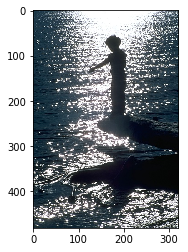

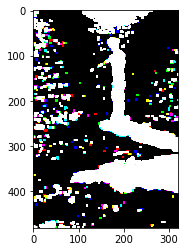

In [128]:
print(images.base_images[0])
plt.imshow(images.base_images[0])
plt.show()
plt.imshow(images.weak_texture_masks[0])
plt.show()

## Sensors

| Sensor ID | Sensor Data |
| --- | --- |
| 0 | weak texture mask |
| 1 | non weak texture mask |

## Actions

| Action ID | Action |
| --- | --- |
| 0 | gaussian_filter_coins sigma 1 | 
| 1 | gaussian_filter_coins sigma 2 |
| 2 | median_filter one(3, 3) |
| 3 | tv_chambolle weight 0.1 |

In [143]:
def denoise_image(image, action_id):
    if action_id == 0:
        return filters.gaussian(image ,sigma=1).astype(numpy.uint8) * 255
    elif action_id == 1:
        return filters.gaussian(image, sigma=1).astype(numpy.uint8) * 255
    elif action_id == 2:
        return restoration.denoise_tv_chambolle(image, weight=0.2).astype(numpy.uint8) 
    elif action_id == 3:
        return restoration.denoise_tv_chambolle(image, weight=0.1).astype(numpy.uint8)

In [144]:
def bits_to_int(bit_list):
    return sum([(x*(2**i)) for i, x in enumerate(bit_list[::-1])])

In [145]:
def extract_weak_texture(image, weak_texture_mask):
    weak_texture = (image * weak_texture_mask).astype(numpy.uint8)
    strong_texture = image - weak_texture
    return strong_texture.astype(numpy.uint8), weak_texture.astype(numpy.uint8)

In [149]:
def evaluate(individual):
    
    weak_texture_action = bits_to_int(individual[0:2])
    strong_texture_action = bits_to_int(individual[2:4])
    print(weak_texture_action, strong_texture_action)
    
    strong_texture, weak_texture = extract_weak_texture(images.noisy_images[0], images.weak_texture_masks[0])
    seperated_textures = numpy.hstack((strong_texture, weak_texture))
    plt.imshow(seperated_textures)
    plt.title("Strong Image Texture | Weak Image Texture ")
    plt.show()
    
    denoised_weak_texture = denoise_image(weak_texture, weak_texture_action)
    denoised_strong_texture = denoise_image(strong_texture, strong_texture_action)
    
    denoised_image = denoised_weak_texture + denoised_strong_texture
    return evaluate_fitness(denoised_image, images.base_images[0], True)
    
    

0 1


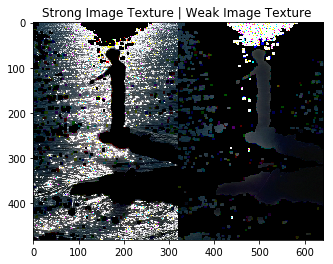

/home/sam/.local/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


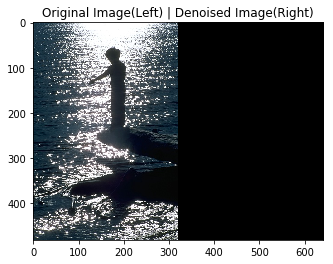

6630.494777918161

In [150]:
evaluate([0,0,0,1])